## Importing packages

In [ ]:
import cv2
from matplotlib import pyplot as plt

import numpy as np
#have done license plate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

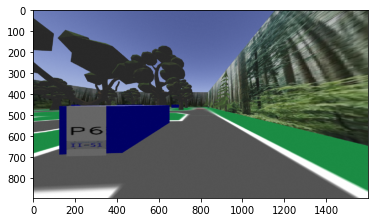

In [ ]:
lp_img = cv2.imread('/content/drive/MyDrive/ENPH353/license_plate.png')
lp_rgb = cv2.cvtColor(lp_img, cv2.COLOR_BGR2RGB)
plt.imshow(lp_rgb)

## Processing Data

1. Find the car
2. Find boundaries of car


### Find the car

In [ ]:
def findingcar(hsv):
  counter = 0
  foundCar = False

  low_blue = np.array([119, 50, 50])
  high_blue = np.array([124, 255, 105])
  blue_mask = cv2.inRange(hsv, low_blue, high_blue) #white pixels in range and black pixels not in range
  blue = cv2.bitwise_and(hsv, hsv, mask=blue_mask) 

  #trying grey instead to get the license plate:
  #low_gray = np.array([0,0,115]) 
  #low_gray = np.array[(162,162,167)]
  #high_gray = np.array([0,0,156])
  #gray_mask = cv2.inRange(hsv, low_gray, high_gray) #white pixels in range and black pixels not in range
  #gray = cv2.bitwise_and(hsv, hsv, mask=gray_mask) 

  #code for displaying the gray part
  indices = np.nonzero(blue_mask)
  size = len(set(zip(indices[0], indices[1])))
  avgX, avgY = 0, 0
  minX, minY = 10000, 10000
  maxX, maxY = -1, -1

  for (x, y) in set(zip(indices[0], indices[1])):
      minX, minY, maxX, maxY = min(minX, x), min(minY, y), max(maxX, x), max(maxY, y)

  rectangle = cv2.rectangle(blue_mask, (minX, minY), (maxX, maxY), (0,0,0), -1)

  gray_rgb = cv2.cvtColor(blue, cv2.COLOR_HSV2RGB)
  grayscale = cv2.cvtColor(gray_rgb, cv2.COLOR_RGB2GRAY)
  _, gray_binary = cv2.threshold(grayscale, 10, 255, cv2.THRESH_BINARY)
  #plt.imshow(blue_rgb)
  #plt.imshow(grayscale, cmap='gray')
  plt.imshow(gray_binary, cmap='gray')

 # print(blue_mask)
 # print(blue)

  count = np.sum(blue_mask)
  
  if count>0:
      foundCar = True
      counter += 1

  #todo: crop image with mask and make the image binary?
  return foundCar, gray_binary

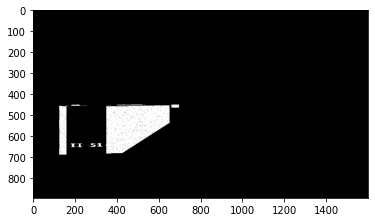

In [ ]:
counter = 0
lp_hsv = hsv = cv2.cvtColor(lp_img, cv2.COLOR_BGR2HSV)

found_car, car_mask = findingcar(lp_hsv) #car_mask is a binary image


### Removing Noise

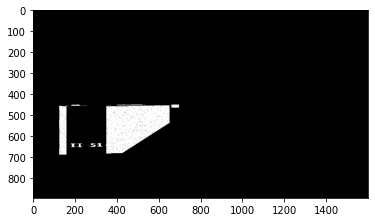

In [ ]:
plt.imshow(car_mask, cmap='gray')

In [ ]:
def closing(carmask):

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
 
  # opening the image
  closed_image = cv2.morphologyEx(carmask, cv2.MORPH_CLOSE, kernel, iterations=1)
 
  # print the output
  plt.figure(figsize = (20,10))
  #plt.imshow(closed_image, cmap='gray')

  return closed_image

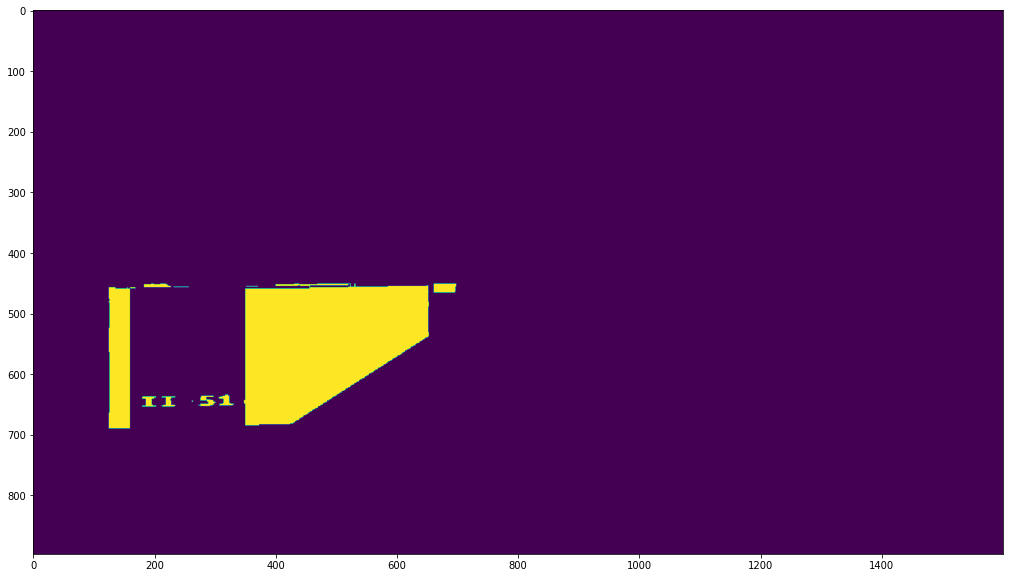

In [ ]:
closed_car_mask = closing(car_mask)
plt.imshow(closed_car_mask)

### Find boundaries of car (For testing; not needed in code)

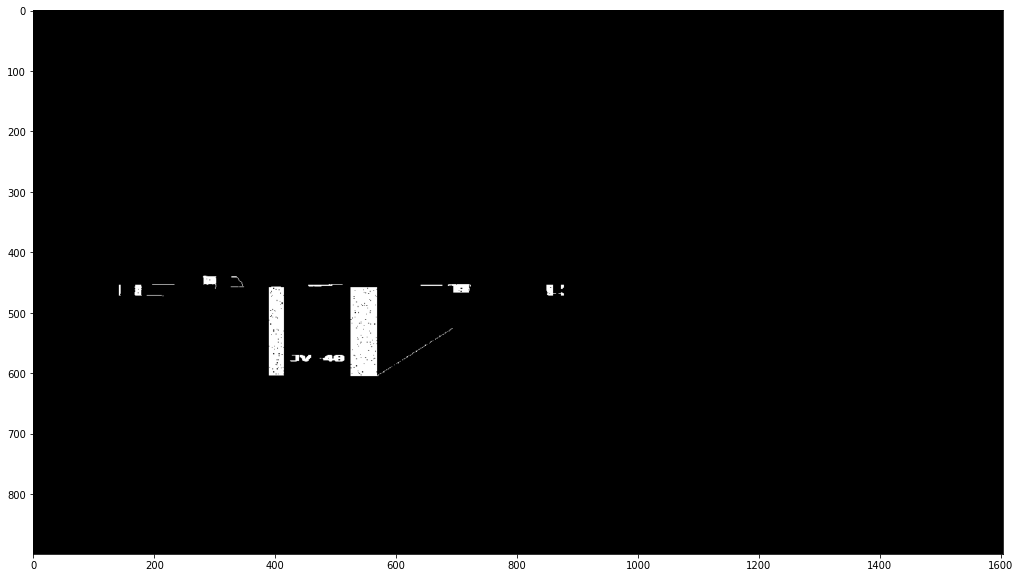

In [ ]:
plt.figure(figsize = (20,10))
plt.imshow(car_mask, cmap="gray")

In [ ]:
def LP_boundaries(image):
  #grayscaled = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(image, (3, 3), 0)
  canny = cv2.Canny(blurred, 120, 255, 1)

  # invert so rectangle is white

# Find contours
  contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Iterate thorugh contours and draw rectangles around contours
  for c in contours:
      x,y,w,h = cv2.boundingRect(c)
      #cv2.rectangle(canny, (x, y), (x + w, y + h), (46,11,244), 2) #last one used to be 2
      #cv2.rectangle(og_img, (x, y), (x + w, y + h), (0,0,255), 2)
      cv2.drawContours(image, c, -1, (0, 255, 0), 3)

  plt.figure(figsize = (20,10))
  plt.imshow(canny)

  return contours

(array([[[262, 644]],
 
        [[262, 645]],
 
        [[263, 645]],
 
        [[263, 644]]], dtype=int32), array([[[213, 637]],
 
        [[212, 638]],
 
        [[218, 638]],
 
        [[219, 639]],
 
        [[219, 650]],
 
        [[218, 651]],
 
        [[215, 651]],
 
        [[214, 652]],
 
        [[212, 652]],
 
        [[213, 653]],
 
        [[232, 653]],
 
        [[233, 652]],
 
        [[234, 652]],
 
        [[233, 651]],
 
        [[228, 651]],
 
        [[227, 650]],
 
        [[227, 644]],
 
        [[226, 643]],
 
        [[226, 641]],
 
        [[227, 640]],
 
        [[227, 639]],
 
        [[228, 638]],
 
        [[233, 638]],
 
        [[234, 637]]], dtype=int32), array([[[181, 637]],
 
        [[180, 638]],
 
        [[180, 640]],
 
        [[185, 640]],
 
        [[186, 641]],
 
        [[186, 651]],
 
        [[185, 652]],
 
        [[180, 652]],
 
        [[180, 653]],
 
        [[202, 653]],
 
        [[202, 652]],
 
        [[198, 652]],
 
        [[197, 6

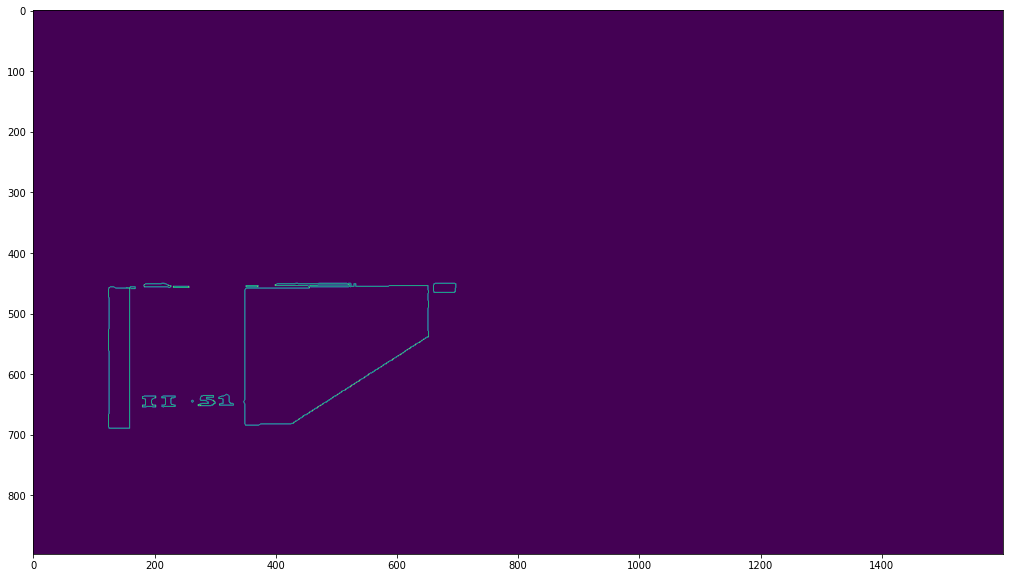

In [ ]:
closed_car_mask_copy = closed_car_mask.copy()
LP_boundaries(closed_car_mask_copy)

### Getting Two Largest Contours

In [ ]:
def twoLargestContours(image):
  #cnts = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  twoContours = []
  areas = []
  dimensions = []
  twoareas = []
  blurred = cv2.GaussianBlur(image, (3, 3), 0)
  canny = cv2.Canny(blurred, 120, 255, 1)
  if (len(contours)==0):
    print("no plates")
  else:
    ordered_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    areas = [cv2.contourArea(c) for c in ordered_contours]
    #print(areas)
    c = max(contours, key = cv2.contourArea)

    largestcontour = ordered_contours[0]
    #print(largestcontour)

#draw it

    contour_color = (0, 255, 0)
    contour_thick = 10
    x, y, w, h = cv2.boundingRect(largestcontour)
    dimensions.append(x)
    dimensions.append(y)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    withcont1 = cv2.drawContours(image_rgb, [largestcontour], 0, contour_color, 10)

    secondlargestcontour = ordered_contours[1]
#draw it
    x_two, y_two, w_two, h_two = cv2.boundingRect(secondlargestcontour)
    dimensions.append(x_two)
    dimensions.append(y_two)
    withcont2 = cv2.drawContours(image_rgb, [secondlargestcontour], 0, contour_color, 10)
    #cv2.rectangle(image, (x_two, y_two), (x_two+w_two, y_two+h_two), (0,255,0), 2)
    #cv2.rectangle(canny, (x_two, y_two), (x_two+w_two, y_two+h_two), (46,14,230), 30)
    
    twoContours = [largestcontour, secondlargestcontour]


  plt.figure(figsize = (20,10))
  #plt.imshow(canny)
  #plt.imshow(lp_rgb)
  plt.imshow(withcont1)

  plt.imshow(withcont2)

  #print(dimensions)

  return twoContours

  #to do: get the boundaries for the two largest contours
        

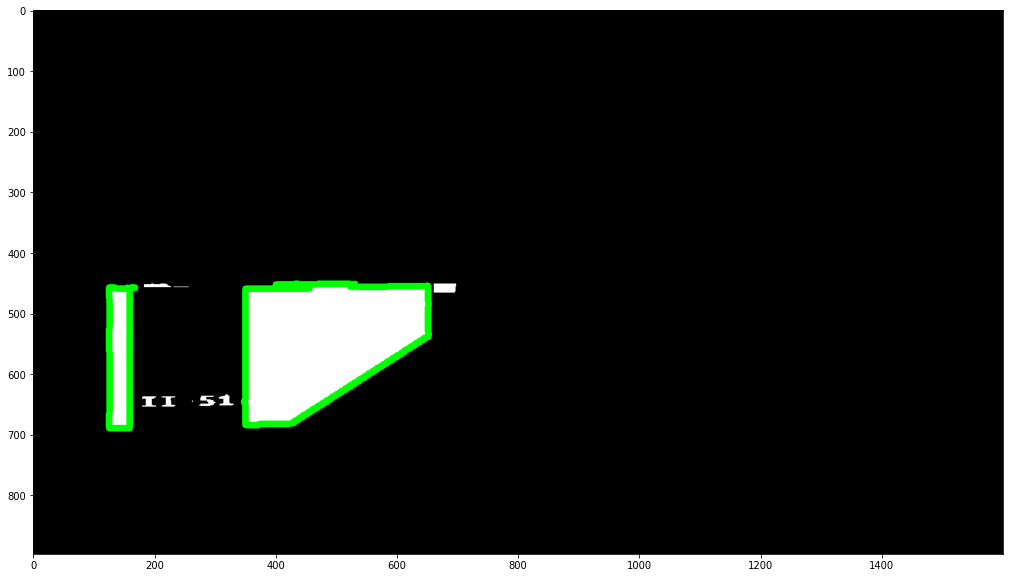

In [ ]:
closed_car_mask_copy = closed_car_mask.copy()
contours = twoLargestContours(closed_car_mask_copy)

In [ ]:
contours[0]

array([[[431, 451]],

       [[430, 452]],

       [[400, 452]],

       [[400, 454]],

       [[436, 454]],

       [[437, 453]],

       [[439, 453]],

       [[440, 454]],

       [[455, 454]],

       [[456, 455]],

       [[456, 458]],

       [[455, 459]],

       [[350, 459]],

       [[350, 642]],

       [[349, 643]],

       [[348, 643]],

       [[348, 648]],

       [[349, 648]],

       [[350, 649]],

       [[350, 684]],

       [[372, 684]],

       [[372, 683]],

       [[373, 682]],

       [[423, 682]],

       [[424, 681]],

       [[428, 681]],

       [[430, 679]],

       [[431, 679]],

       [[431, 678]],

       [[432, 677]],

       [[433, 677]],

       [[434, 676]],

       [[435, 676]],

       [[436, 675]],

       [[438, 675]],

       [[438, 674]],

       [[440, 672]],

       [[441, 672]],

       [[442, 671]],

       [[443, 671]],

       [[444, 670]],

       [[445, 670]],

       [[445, 669]],

       [[447, 667]],

       [[449, 667]],

       [[4

### Getting Image with Parking Number and License Plate
(only need function at end)

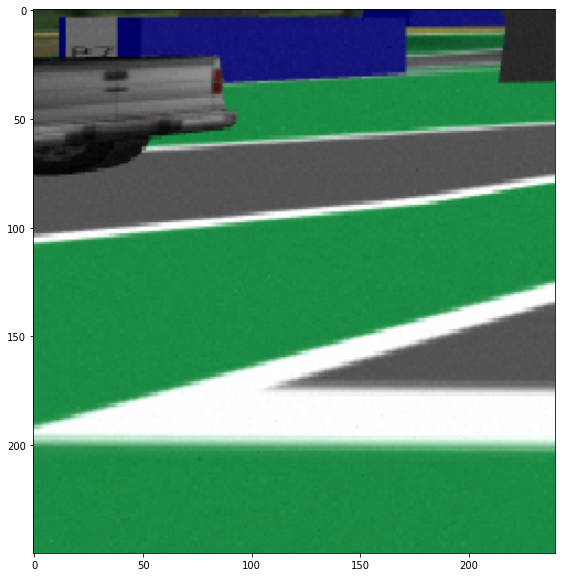

In [ ]:
lp_rgb_copy = lp_rgb.copy()
#withcont2 = cv2.drawContours(lp_rgb_copy, [contours[0]], 0, (255, 0, 0), 10)

plt.figure(figsize = (20,10))

#plt.imshow(lp_rgb)
#plt.imshow(withcont1)
plt.imshow(lp_rgb[450:700, 130:370])

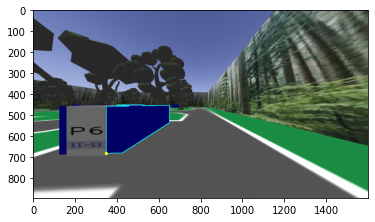

In [ ]:
c = contours[0]

extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

lp_rgb_copy_2 = lp_rgb.copy()

x, y, w, h = cv2.boundingRect(c)


cv2.drawContours(lp_rgb_copy_2, [c], -1, (0, 255, 255), 2)
#cv2.circle(lp_rgb_copy_2, extLeft, 8, (0, 0, 255), -1)
#cv2.circle(lp_rgb_copy_2, extRight, 8, (0, 255, 0), -1)
#cv2.circle(lp_rgb_copy_2, extTop, 8, (255, 0, 0), -1)
cv2.circle(lp_rgb_copy_2, extBot, 8, (255, 255, 0), -1) # gives bottom left
# show the output image
plt.imshow(lp_rgb_copy_2)
    

[[348 451]
 [652 451]
 [652 684]
 [348 684]]
652


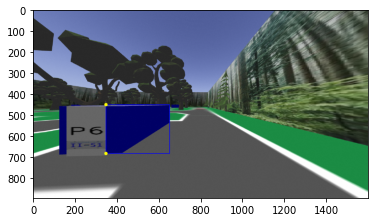

In [ ]:
lp_rgb_copy_3 = lp_rgb.copy()

rect = cv2.minAreaRect(c)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(lp_rgb_copy_3,[box],0,(0,0,255),2)
#plt.imshow(lp_rgb_copy_3)

print(box)

minx = np.min(box[:,0])
miny = np.min(box[:,1])

maxx = np.max(box[:,0])
maxy = np.max(box[:,1])

print(maxx)

#extTop = tuple(box[box[:, 1].argmin()][0])
#extLeft = tuple(box[box[:, 0].argmin()][0])


cv2.circle(lp_rgb_copy_3, (minx, miny), 8, (255, 255, 0), -1) # gives bottom left
cv2.circle(lp_rgb_copy_3, (minx, maxy), 8, (255, 255, 0), -1) # gives bottom left

plt.imshow(lp_rgb_copy_3)


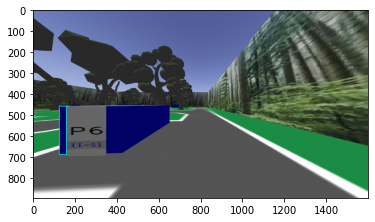

In [ ]:
c8 = contours[1]

#extLeft = tuple(c8[c8[:, :, 0].argmin()][0])
#extRight = tuple(c8[c8[:, :, 0].argmax()][0])
#extTop = tuple(c8[c8[:, :, 1].argmin()][0])
#extBot = tuple(c8[c8[:, :, 1].argmax()][0])

lp_rgb_copy_5 = lp_rgb.copy()

x, y, w, h = cv2.boundingRect(c8)


cv2.drawContours(lp_rgb_copy_5, [c8], -1, (0, 255, 255), 2)
#cv2.circle(lp_rgb_copy_2, extLeft, 8, (0, 0, 255), -1)
#cv2.circle(lp_rgb_copy_2, extRight, 8, (0, 255, 0), -1)
#cv2.circle(lp_rgb_copy_2, extTop, 8, (255, 0, 0), -1)
#cv2.circle(lp_rgb_copy_2, extBot, 8, (255, 255, 0), -1) # gives bottom left
# show the output image
plt.imshow(lp_rgb_copy_5)
    

[[125 457]
 [168 457]
 [168 689]
 [125 689]]
168


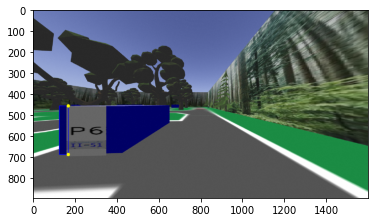

In [ ]:
lp_rgb_copy_new = lp_rgb.copy()

c_new = contours[1]

rect_new = cv2.minAreaRect(c_new)
box_new = cv2.boxPoints(rect_new)
box_new = np.int0(box_new)
cv2.drawContours(lp_rgb_copy_new,[box_new],0,(0,0,255),2)
#plt.imshow(lp_rgb_copy_new)

print(box_new)

minx = np.min(box_new[:,0])
miny = np.min(box_new[:,1])

maxx = np.max(box_new[:,0])
maxy = np.max(box_new[:,1])

#print(miny)
#print(maxy)

#print(maxx)
print(maxx)
#extTop = tuple(box[box[:, 1].argmin()][0])
#extLeft = tuple(box[box[:, 0].argmin()][0])


cv2.circle(lp_rgb_copy_new, (maxx, miny), 8, (255, 255, 0), -1) # gives bottom left
cv2.circle(lp_rgb_copy_new, (maxx, maxy), 8, (255, 255, 0), -1) # gives bottom left

plt.imshow(lp_rgb_copy_new)

In [ ]:
def four_corner_points(image, contours):
  largest_contour = contours[0]
  second_largest_contour = contours[1]

  rect_largest = cv2.minAreaRect(largest_contour)
  box_largest = cv2.boxPoints(rect_largest)
  box_largest = np.int0(box_largest)

  minx_1 = np.min(box_largest[:,0])
  miny_1 = np.min(box_largest[:,1])

  maxx_1 = np.max(box_largest[:,0])
  maxy_1 = np.max(box_largest[:,1])

  rect_second_largest = cv2.minAreaRect(second_largest_contour)
  box_second_largest = cv2.boxPoints(rect_second_largest)
  box_second_largest = np.int0(box_second_largest)

  minx_2 = np.min(box_second_largest[:,0])
  miny_2 = np.min(box_second_largest[:,1])

  maxx_2 = np.max(box_second_largest[:,0])
  maxy_2 = np.max(box_second_largest[:,1])

  #if largest to the right
  if maxx_1>maxx_2:
    right_bot = (minx_1, maxy_1)
    right_top = (minx_1, miny_1)
    left_bot = (maxx_2, maxy_2)
    left_top = (maxx_2, miny_2)
  #if largest to the left
  if maxx_1<maxx_2:
    right_bot = (minx_2, maxy_2)
    right_top = (minx_2, miny_2)
    left_bot = (maxx_1, maxy_1)
    left_top = (maxx_1, miny_1)

  cv2.circle(image, right_bot, 8, (255, 255, 0), -1) # gives bottom left
  cv2.circle(image, right_top, 8, (255, 255, 0), -1) # gives bottom left
  cv2.circle(image, left_bot, 8, (255, 255, 0), -1) # gives bottom left
  cv2.circle(image, left_top, 8, (255, 255, 0), -1) # gives bottom left

  new_image = image[left_top[1]:left_bot[1],left_bot[0]:right_bot[0]]
   
  height = new_image.shape[0]
  width = new_image.shape[1]

  plt.imshow(new_image)

  return new_image, height, width, right_bot, right_top, left_bot, left_top

#extTop = tuple(box[box[:, 1].argmin()][0])
#extLeft = tuple(box[box[:, 0].argmin()][0])

(348, 684)
1.288888888888889
232
180


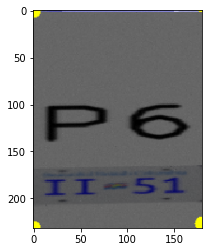

In [ ]:
lp_rgb_copy_testing_2 = lp_rgb.copy()
copyforcont = closed_car_mask.copy()

imagewanted, height, width, rb, rt, lb, lt = four_corner_points(lp_rgb_copy_testing_2, contours)
print(rb)
ratio = height/width
print(ratio)
print(height)
print(width)

### Perspective Transform

In [ ]:
pts1 = np.float32([rb, rt, lb, lt])
pts2 = np.float32([[0,0], [600,298], [0,298], [600,0]])

M = cv2.getPerspectiveTransform(imagewanted, [rb, rt, lb, lt], [[0,0], [600,298], [0,298], [600,0]])

plt.imshow(M)

error: ignored

### Separating Parking Number and License Plate and Doing a Perspective Transform

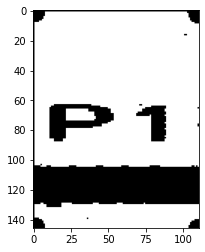

In [ ]:
imagewanted_copy = imagewanted.copy()
image_hsv = cv2.cvtColor(imagewanted_copy, cv2.COLOR_BGR2HSV)

#(117,117, 0), (255,255,255)
# BEST SO FAR (0,0,50), (69,69,255))
#high_gray = np.array([255, 255, 255])
#low_gray = np.array([117, 117, 0])
#low_gray = np.array([141, 1, 43])
gray_mask = cv2.inRange(image_hsv, (0,0,90), (0,0,210)) #white pixels in range and black pixels not in range
gray = cv2.bitwise_and(image_hsv, image_hsv, mask=gray_mask) 

  #trying grey instead to get the license plate:
  #low_gray = np.array([0,0,115]) 
  #low_gray = np.array[(162,162,167)]
  #high_gray = np.array([0,0,156])
  #gray_mask = cv2.inRange(hsv, low_gray, high_gray) #white pixels in range and black pixels not in range
  #gray = cv2.bitwise_and(hsv, hsv, mask=gray_mask) 

  #code for displaying the gray part
#indices = np.nonzero(gray_mask)
#size = len(set(zip(indices[0], indices[1])))
#avgX, avgY = 0, 0
#minX, minY = 10000, 10000
#maxX, maxY = -1, -1

#for (x, y) in set(zip(indices[0], indices[1])):
#  minX, minY, maxX, maxY = min(minX, x), min(minY, y), max(maxX, x), max(maxY, y)

#rectangle = cv2.rectangle(gray_mask, (minX, minY), (maxX, maxY), (0,0,0), -1)

gray_rgb = cv2.cvtColor(gray, cv2.COLOR_HSV2RGB)
grayscale = cv2.cvtColor(gray_rgb, cv2.COLOR_RGB2GRAY)
_, gray_binary = cv2.threshold(grayscale, 10, 255, cv2.THRESH_BINARY)
  #plt.imshow(blue_rgb)
  #plt.imshow(grayscale, cmap='gray')
plt.imshow(gray_binary, cmap='gray')

 # print(blue_mask)
 # print(blue)



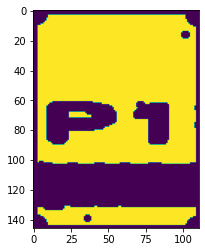

In [ ]:
copy2 = gray_binary.copy()

  #grayscaled = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # invert so rectangle is white

# Find contours
contours, hierarchy = cv2.findContours(copy2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)# Iterate thorugh contours and draw rectangles around contours
cv2.drawContours(copy2, contours, -1, (0, 0, 255), 2)

plt.imshow(copy2)


<Figure size 1440x720 with 0 Axes>

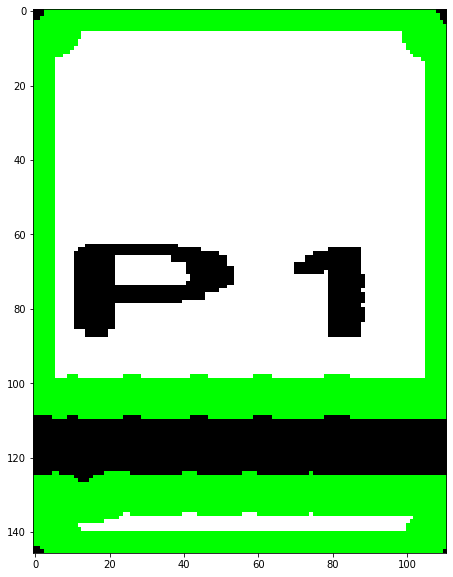

In [ ]:
copy5 = gray_binary.copy()

closed_copy5 = closing(copy5)

contours, dimension = twoLargestContours(closed_copy5)

In [ ]:
def separatingimages(image):
  image_hsv = cv2.cvtColor(imagewanted_copy, cv2.COLOR_BGR2HSV)

#(117,117, 0), (255,255,255)
# BEST SO FAR (0,0,50), (69,69,255))
#high_gray = np.array([255, 255, 255])
#low_gray = np.array([117, 117, 0])
#low_gray = np.array([141, 1, 43])
  gray_mask = cv2.inRange(image_hsv, (0,0,90), (0,0,210)) #white pixels in range and black pixels not in range
  gray = cv2.bitwise_and(image_hsv, image_hsv, mask=gray_mask) 

  #trying grey instead to get the license plate:
  #low_gray = np.array([0,0,115]) 
  #low_gray = np.array[(162,162,167)]
  #high_gray = np.array([0,0,156])
  #gray_mask = cv2.inRange(hsv, low_gray, high_gray) #white pixels in range and black pixels not in range
  #gray = cv2.bitwise_and(hsv, hsv, mask=gray_mask) 

  #code for displaying the gray part
#indices = np.nonzero(gray_mask)
#size = len(set(zip(indices[0], indices[1])))
#avgX, avgY = 0, 0
#minX, minY = 10000, 10000
#maxX, maxY = -1, -1

#for (x, y) in set(zip(indices[0], indices[1])):
#  minX, minY, maxX, maxY = min(minX, x), min(minY, y), max(maxX, x), max(maxY, y)

#rectangle = cv2.rectangle(gray_mask, (minX, minY), (maxX, maxY), (0,0,0), -1)

  gray_rgb = cv2.cvtColor(gray, cv2.COLOR_HSV2RGB)
  grayscale = cv2.cvtColor(gray_rgb, cv2.COLOR_RGB2GRAY)
  _, gray_binary = cv2.threshold(grayscale, 10, 255, cv2.THRESH_BINARY)
  #plt.imshow(blue_rgb)
  #plt.imshow(grayscale, cmap='gray')
  #plt.imshow(gray_binary, cmap='gray')


  closed_bin = closing(gray_binary)

  plt.imshow(closed_bin, cmap='gray')

  return closed_bin




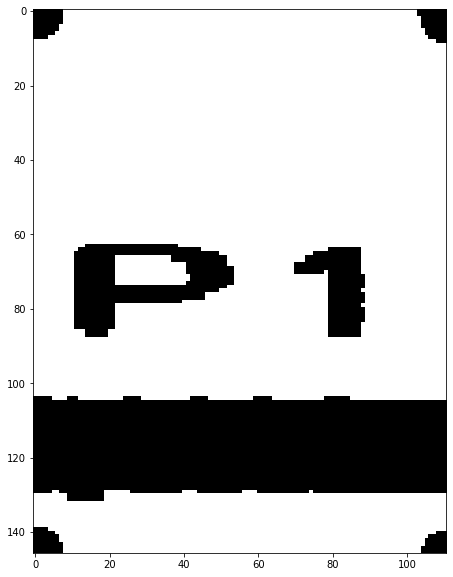

In [ ]:
imagewanted_copy9 = imagewanted.copy()
closed_plate = separatingimages(imagewanted_copy9)

In [ ]:
def finding_parkingplate_contours(image):
  contours = twoLargestContours(image)
  return contours

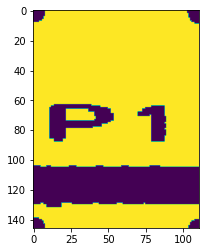

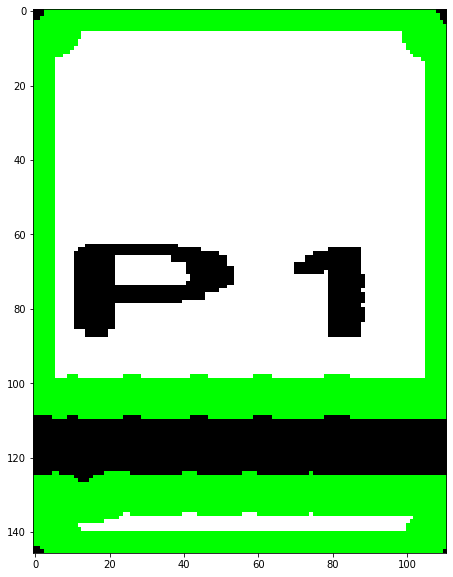

In [ ]:
closed_plate_copy = closed_plate.copy()
plt.imshow(closed_plate_copy)
contours_parking = finding_parkingplate_contours(closed_plate_copy) 
contours_parking.size()

In [ ]:
def four_corner_points_parking(image, contours):
  largest_contour = contours[0]
  #second_largest_contour = contours[1]

  rect_largest = cv2.minAreaRect(largest_contour)
  box_largest = cv2.boxPoints(rect_largest)
  box_largest = np.int0(box_largest)

  minx_1 = np.min(box_largest[:,0])
  miny_1 = np.min(box_largest[:,1])

  maxx_1 = np.max(box_largest[:,0])
  maxy_1 = np.max(box_largest[:,1])

  #rect_second_largest = cv2.minAreaRect(second_largest_contour)
  #box_second_largest = cv2.boxPoints(rect_second_largest)
  #box_second_largest = np.int0(box_second_largest)

  #minx_2 = np.min(box_second_largest[:,0])
  #miny_2 = np.min(box_second_largest[:,1])

  #maxx_2 = np.max(box_second_largest[:,0])
  #maxy_2 = np.max(box_second_largest[:,1])

  right_bot = (maxx_1, maxy_1)
  right_top = (maxx_1, miny_1)
  left_bot = (minx_1, maxy_1)
  left_top = (minx_1, miny_1)

  cv2.circle(image, right_bot, 8, (255, 255, 0), -1) # gives bottom left
  cv2.circle(image, right_top, 8, (255, 255, 0), -1) # gives bottom left
  cv2.circle(image, left_bot, 8, (255, 255, 0), -1) # gives bottom left
  cv2.circle(image, left_top, 8, (255, 255, 0), -1) # gives bottom left

  new_image = image[left_top[1]:left_bot[1],left_bot[0]:right_bot[0]]

  plt.imshow(new_image)

  return new_image, right_bot, right_top, left_bot, left_top

[array([[[  8,   0]],

       [[  8,   3]],

       [[  7,   4]],

       [[  7,   5]],

       [[  5,   7]],

       [[  4,   7]],

       [[  3,   8]],

       [[  0,   8]],

       [[  0, 103]],

       [[  4, 103]],

       [[  5, 104]],

       [[  8, 104]],

       [[  9, 103]],

       [[ 11, 103]],

       [[ 12, 104]],

       [[ 23, 104]],

       [[ 24, 103]],

       [[ 28, 103]],

       [[ 29, 104]],

       [[ 41, 104]],

       [[ 42, 103]],

       [[ 46, 103]],

       [[ 47, 104]],

       [[ 58, 104]],

       [[ 59, 103]],

       [[ 63, 103]],

       [[ 64, 104]],

       [[ 77, 104]],

       [[ 78, 103]],

       [[ 84, 103]],

       [[ 85, 104]],

       [[110, 104]],

       [[110,   9]],

       [[108,   9]],

       [[107,   8]],

       [[106,   8]],

       [[104,   6]],

       [[104,   5]],

       [[103,   4]],

       [[103,   2]],

       [[102,   1]],

       [[102,   0]]], dtype=int32), array([[[  5, 129]],

       [[  4, 130]],

       [[  0, 130

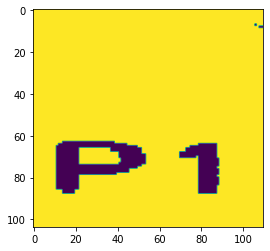

In [ ]:
closed_plate_copy5 = closed_plate.copy()

newimg, rb1, rt1, lb1, lt1 = four_corner_points_parking(closed_plate_copy5, contours_parking)
print(contours_parking)

(110, 0)
(110, 104)
(0, 104)
(0, 0)


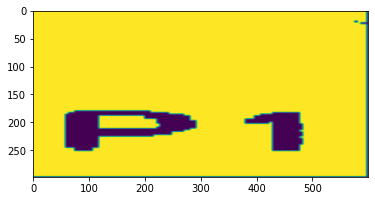

In [ ]:
print(rt1)
print(rb1)

print(lb1)
print(lt1)

newimg_copy = newimg.copy()
pts1 = np.float32([lt1, rb1, lb1, rt1])
pts2 = np.float32([[0,0], [600,298], [0,298], [600,0]])

M = cv2.getPerspectiveTransform(pts1, pts2)
dst = cv2.warpPerspective(newimg_copy, M, (600,298))
plt.imshow(dst)

In [ ]:
def four_corner_points_license_plate(image, contours):
  largest_contour = contours[0]
  second_largest_contour = contours[1]

  rect_largest = cv2.minAreaRect(largest_contour)
  box_largest = cv2.boxPoints(rect_largest)
  box_largest = np.int0(box_largest)

  minx_1 = np.min(box_largest[:,0])
  miny_1 = np.min(box_largest[:,1])

  maxx_1 = np.max(box_largest[:,0])
  maxy_1 = np.max(box_largest[:,1])

  rect_second_largest = cv2.minAreaRect(second_largest_contour)
  box_second_largest = cv2.boxPoints(rect_second_largest)
  box_second_largest = np.int0(box_second_largest)

  minx_2 = np.min(box_second_largest[:,0])
  miny_2 = np.min(box_second_largest[:,1])

  maxx_2 = np.max(box_second_largest[:,0])
  maxy_2 = np.max(box_second_largest[:,1])


  right_bot = (maxx_2, miny_2)
  right_top = (maxx_2, maxy_1)
  left_bot = (minx_2, miny_2)
  left_top = (minx_2, maxy_1)
  
  cv2.circle(image, right_bot, 8, (255, 255, 0), -1) # gives bottom left
  cv2.circle(image, right_top, 8, (255, 255, 0), -1) # gives bottom left
  cv2.circle(image, left_bot, 8, (255, 255, 0), -1) # gives bottom left
  cv2.circle(image, left_top, 8, (255, 255, 0), -1) # gives bottom left

  new_image = image[left_top[1]:left_bot[1],left_bot[0]:right_bot[0]]

  new_image.resize(())

  plt.imshow(new_image)

  return new_image

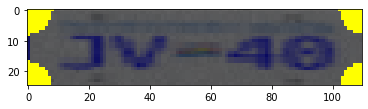

In [ ]:
imagewantedcopyfun = imagewanted.copy()
licenseplate = four_corner_points_license_plate(imagewantedcopyfun, contours_parking)

(0, 0)
(110, 104)
(0, 104)
(110, 0)


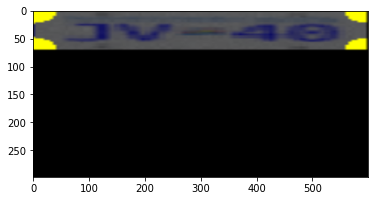

In [ ]:
print(lt1)
print(rb1)
print(lb1)
print(rt1)
lp_copy = licenseplate.copy()
pts1 = np.float32([lt1, rb1, lb1, rt1])
pts2 = np.float32([[0,0], [600,298], [0,298], [600,0]])

M = cv2.getPerspectiveTransform(pts1, pts2)
dst = cv2.warpPerspective(lp_copy, M, (600,298))
plt.imshow(dst)

In [ ]:
#todo: 
#run a perspective transform

## General Functionalities

### Making an Image Binary

In [ ]:
def makebinary(img):
  grayscale = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  binaryImg = cv2.threshold(grayscale, 10, 255, cv2.THRESH_BINARY)

  return binaryImg

In [ ]:
    #areas = [cv2.contourArea(c) for c in cnts]
    #max_index = np.argmax(areas)
    #cnt = cnts[max_index]
    #x,y,w,h = cv2.boundingRect(cnt)
    #cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    #twoContours.append(cnt)
    #cnts = np.delete(cnt, max_index)
    
    #max_index_two = np.argmax(areas)
    #cnt2 = cnts[max_index_two]
    #x_two,y_two,w_two,h_two = cv2.boundingRect(cnt2)
    #cv2.rectangle(image,(x_two,y_two),(x_two+w_two,y_two+h_two),(0,255,0),2)
    #twoContours.append(cnt2)
    #cnts = np.delete(cnt2, max_index_two)

  
    
    #

    #for contour in cnts:
      #new
      
    #  x, y, w, h = cv2.boundingRect(contour)
    #  aspect_ratio = float(w) / h

    #  areas.append((x + w)*(y + h))
        # to do: figure out how to get the cropped plate
  #largest_area = max(areas)  #  39
  #index_value_max = areas.index(largest_area)
  #areas.remove(largest_area)
  #twoareas.append(largest_area)

  #second_largest_area = max(areas)  # 26  
  #index_value_second_max = areas.index(second_largest_area)
  #twoareas.append(second_largest_area)

  #twoContours.append(cnts[index_value_max])
  #twoContours.append(cnts[index_value_second_max])

  #for c in twoContours:
   # x,y,w,h = cv2.boundingRect(c)
    #cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,0), 2) #last one used to be 2

In [ ]:
#!/usr/bin/env python

import numpy as np
import cv2 as cv
import time

imagewanted_copy = cv.imread('blacktape.png',cv.IMREAD_COLOR)
imagewanted_copy = cv.medianBlur(img,5)

# Convert BGR to HSV
hsv = cv.cvtColor(imagewanted_copy, cv.COLOR_BGR2HSV)

uh = 130
us = 255
uv = 255
lh = 110
ls = 50
lv = 50
lower_hsv = np.array([lh,ls,lv])
upper_hsv = np.array([uh,us,uv])

# Threshold the HSV image to get only blue colors
mask = cv.inRange(hsv, lower_hsv, upper_hsv)
window_name = "HSV Calibrator"
cv.namedWindow(window_name)

def nothing(x):
    print("Trackbar value: " + str(x))
    pass

# create trackbars for Upper HSV
cv.createTrackbar('UpperH',window_name,0,255,nothing)
cv.setTrackbarPos('UpperH',window_name, uh)

cv.createTrackbar('UpperS',window_name,0,255,nothing)
cv.setTrackbarPos('UpperS',window_name, us)

cv.createTrackbar('UpperV',window_name,0,255,nothing)
cv.setTrackbarPos('UpperV',window_name, uv)

# create trackbars for Lower HSV
cv.createTrackbar('LowerH',window_name,0,255,nothing)
cv.setTrackbarPos('LowerH',window_name, lh)

cv.createTrackbar('LowerS',window_name,0,255,nothing)
cv.setTrackbarPos('LowerS',window_name, ls)

cv.createTrackbar('LowerV',window_name,0,255,nothing)
cv.setTrackbarPos('LowerV',window_name, lv)

font = cv.FONT_HERSHEY_SIMPLEX

print("Loaded images")

while(1):
    # Threshold the HSV image to get only blue colors
    mask = cv.inRange(hsv, lower_hsv, upper_hsv)
    cv.putText(mask,'Lower HSV: [' + str(lh) +',' + str(ls) + ',' + str(lv) + ']', (10,30), font, 0.5, (200,255,155), 1, cv.LINE_AA)
    cv.putText(mask,'Upper HSV: [' + str(uh) +',' + str(us) + ',' + str(uv) + ']', (10,60), font, 0.5, (200,255,155), 1, cv.LINE_AA)

    cv.imshow(window_name,mask)

    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
    # get current positions of Upper HSV trackbars
    uh = cv.getTrackbarPos('UpperH',window_name)
    us = cv.getTrackbarPos('UpperS',window_name)
    uv = cv.getTrackbarPos('UpperV',window_name)
    upper_blue = np.array([uh,us,uv])
    # get current positions of Lower HSCV trackbars
    lh = cv.getTrackbarPos('LowerH',window_name)
    ls = cv.getTrackbarPos('LowerS',window_name)
    lv = cv.getTrackbarPos('LowerV',window_name)
    upper_hsv = np.array([uh,us,uv])
    lower_hsv = np.array([lh,ls,lv])

    time.sleep(.1)

cv.destroyAllWindows()

error: ignored